In [1]:
# -*- coding: utf-8 -*-
import os, glob
from typing import List, Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def main(dataset: str, csv_patterns: List[str], nlow: int, title: str, error_bar: bool=False, path: str=""):
    # ===== 기본 설정 (간결화) =====
    EXCLUDE_MINMAX_SEED = True

    FAIRNESS_KEYS = [
        'sup_w1_over_V_[1, 2, 3]',  # → supIPM
        'supipm_rbf',                # → MMD
        'supipm_w1',                 # → WD
        'spd_worst',                 # → SP_max
        'spd_mean',                  # → SP_avg
        'marg_spd_worst',            # → MP_max
        'marg_spd_mean',             # → MP_avg
    ]
    XLABEL = {
        'sup_w1_over_V_[1, 2, 3]': 'supIPM',
        'supipm_rbf': 'MMD',
        'supipm_w1': 'WD',
        'spd_worst': 'SP_max',
        'spd_mean': 'SP_avg',
        'marg_spd_worst': 'MP_max',
        'marg_spd_mean': 'MP_avg',
    }

    MARKERS = {"dr": "o", "reduction": "s", "gerryfair": "^", "multicalib": "D", "sequential": "P", "reg": "*", "unfair": "v"}
    COLOR_BY_BASE = {
        "dr": "#1f77b4", "reduction": "#ff7f0e", "gerryfair": "#2ca02c",
        "multicalib": "#d62728", "sequential": "#9467bd", "unfair": "black", "reg": "#e377c2",
    }
    LABEL_MAP = {
        "unfair": "Unfair",
        "dr": r"DR $\checkmark$",
        "gerryfair": "GF",
        "reg": "REG",
        "sequential": "SEQ",
        "reduction": "RED",
        "multicalib": "MC",
    }

    plt.rcParams.update({
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
    })

    METHOD_CANON = {
        "dr": "dr", "dr_subgroup_subset": "dr", "dr_subgroup_subset_3q": "dr", "dr_subgroup_subset_random": "dr",
        "gerry": "gerryfair", "gerryfair": "gerryfair", "multicalib": "multicalib",
        "seq": "sequential", "sequential": "sequential", "red": "reduction", "reduction": "reduction",
        "reg": "reg", "unfair": "unfair"
    }
    CONTROL_COLS_PRIMARY = {
        "dr": ["lambda_fair"], "reduction": ["red_eps"], "gerryfair": ["gamma"],
        "multicalib": ["mc_alpha"], "sequential": ["seq_alpha"], "reg": ["reg_lambda"], "unfair": []
    }
    CONTROL_COLS_FALLBACK = {
        "dr": ["n_low", "n_low_frac", "shrink_smallest_frac"],
        "reduction": ["red_constraint", "red_max_iter"],
        "gerryfair": ["gf_max_iters", "gf_C"],
        "multicalib": ["mc_lambda", "mc_max_iter"],
        "sequential": ["seq_max_iter"],
    }

    def canon_method(m: str) -> str:
        if m is None: return "unknown"
        m = str(m)
        if m in METHOD_CANON: return METHOD_CANON[m]
        for k, v in METHOD_CANON.items():
            if m.startswith(k): return v
        return m

    def pick_control_col(sub_df: pd.DataFrame, method_raw: str) -> Optional[str]:
        base = canon_method(method_raw)
        for c in CONTROL_COLS_PRIMARY.get(base, []):
            if c in sub_df.columns and sub_df[c].nunique(dropna=True) > 1:
                return c
        for c in CONTROL_COLS_FALLBACK.get(base, []):
            if c in sub_df.columns and sub_df[c].nunique(dropna=True) > 1:
                return c
        return None

    def pareto_front_xy(x, y, eps=1e-9):
        # x 낮을수록 공정, y 높을수록 정확 → 비지배 집합
        x = np.asarray(x, float); y = np.asarray(y, float)
        ok = np.isfinite(x) & np.isfinite(y)
        if not ok.any(): return np.array([], dtype=int)
        order = np.lexsort((-y[ok], x[ok]))  # x asc, y desc
        xs, ys = x[ok][order], y[ok][order]
        idxs = np.arange(len(x))[ok][order]
        keep, best_y = [], -np.inf
        for xi, yi, ii in zip(xs, ys, idxs):
            if yi >= best_y - eps:
                keep.append(ii)
                if yi > best_y: best_y = yi
        return np.array(sorted(keep, key=lambda i: x[i]), dtype=int)

    def coerce_float_safe(v) -> float:
        try: return float(v)
        except Exception: return np.nan

    def mean_excl_minmax(v):
        a = np.asarray(list(v), float)
        a = a[np.isfinite(a)]
        if EXCLUDE_MINMAX_SEED and a.size >= 3:
            a = np.sort(a)[1:-1]
        return float(np.mean(a)) if a.size > 0 else np.nan
    
    def _fmt_num(v: float) -> str:
        # 정수면 정수로, 아니면 유효숫자 3자리
        try:
            v = float(v)
        except Exception:
            return ""
        if abs(v - round(v)) < 1e-9 and abs(v) < 1e6:
            return str(int(round(v)))
        return f"{v:.3g}"

    # ---------- 데이터 로드 ----------
    files: List[str] = []
    for pat in csv_patterns: files.extend(sorted(glob.glob(pat)))
    if not files: raise FileNotFoundError("CSV_PATTERNS에 맞는 파일이 없습니다.")
    frames = []
    for fp in files:
        try:
            df = pd.read_csv(fp)
            df["__source_file"] = fp
            frames.append(df)
        except Exception as e:
            print(f"[WARN] 읽기 실패: {fp} ({e})")
    df_all = pd.concat(frames, ignore_index=True, sort=False)
    if "dataset" not in df_all.columns: raise KeyError("CSV에 'dataset' 컬럼이 없습니다.")
    df = df_all[df_all["dataset"] == dataset].copy()
    if df.empty: raise ValueError(f"dataset=='{dataset}' 인 행이 없습니다.")

    os.makedirs(path, exist_ok=True)

    # ---------- 지표별 개별 그림 ----------
    base_title = dataset[:1].upper() + dataset[1:].lower()
    ALPHA_POINTS = 0.6
    DPI = 220

    for FAIRNESS_KEY in FAIRNESS_KEYS:
        if FAIRNESS_KEY not in df.columns:
            print(f"[WARN] '{FAIRNESS_KEY}' 없음 → skip")
            continue

        fig, ax = plt.subplots(figsize=(6.8, 4.4))

        tmp = df.copy()
        tmp["fairness_scalar"] = tmp[FAIRNESS_KEY].map(coerce_float_safe)
        if "accuracy" not in tmp.columns: raise KeyError("CSV에 'accuracy' 컬럼이 없습니다.")
        tmp["accuracy"] = tmp["accuracy"].map(coerce_float_safe)
        tmp = tmp[np.isfinite(tmp["fairness_scalar"]) & np.isfinite(tmp["accuracy"])].copy()
        if tmp.empty:
            plt.close(fig)
            continue

        methods = sorted(tmp["method"].dropna().unique().tolist())
        cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))
        def get_color(base):
            return COLOR_BY_BASE.get(base, cmap(hash(base) % cmap.N))

        method_label_used: Dict[str, bool] = {}

        for mname in methods:
            sub = tmp[tmp["method"] == mname].copy()
            if sub.empty: continue
            base = canon_method(mname)
            color = get_color(base)
            marker = MARKERS.get(base, "o")
            ctrl = pick_control_col(sub, mname)
            if base == "sequential":
                ctrl = None

            # ctrl 없으면 seed-평균 1점 (자동으로 front)
            if ctrl is None and "seed" in sub.columns:
                grp = sub.groupby(["seed"], dropna=False).agg(
                    fair=("fairness_scalar", mean_excl_minmax),
                    acc=("accuracy",       mean_excl_minmax),
                ).reset_index()
                x = mean_excl_minmax(grp["fair"].values)
                y = mean_excl_minmax(grp["acc"].values)
                lbl = LABEL_MAP.get(base, base.title()) if not method_label_used.get(base, False) else None
                ax.scatter([x], [y], s=50, marker=marker, color=color, alpha=ALPHA_POINTS, label=lbl, zorder=3)
                method_label_used[base] = True
                continue

            if ctrl is None:
                continue  # seed도 없으면 스킵

            needed = ["fairness_scalar", "accuracy", "seed", ctrl]
            if any(c not in sub.columns for c in needed):
                continue

            grp = (sub.groupby([ctrl, "seed"], dropna=False)
                     .agg(fair=("fairness_scalar", mean_excl_minmax),
                          acc=("accuracy",       mean_excl_minmax))
                     .reset_index()
                     .rename(columns={ctrl: "ctrl"}))

            agg = grp.groupby("ctrl", dropna=False).agg(
                x=("fair", mean_excl_minmax),
                y=("acc",  mean_excl_minmax),
            ).reset_index()
            if agg.empty: continue

            # # === Pareto front만 선택 ===
            # pf_idx = pareto_front_xy(agg["x"].values, agg["y"].values, eps=1e-9)
            # if pf_idx.size == 0:
            #     continue
            # front = agg.iloc[pf_idx].copy().sort_values("x", ascending=False).reset_index(drop=True)
            front = agg

            # DR: λ=0은 front 여부와 무관하게 항상 Unfair로 그림
            if base == "dr" and ctrl == "lambda_fair":
                try:
                    # ⬇︎ 기존: front 기준 → 변경: agg 기준(항상 표시)
                    is_unfair_all = np.isclose(agg["ctrl"].astype(float).values, 0.0)
                except Exception:
                    is_unfair_all = np.zeros(len(agg), dtype=bool)

                agg_unfair = agg[is_unfair_all]
                if not agg_unfair.empty:
                    lbl_unf = LABEL_MAP["unfair"] if not method_label_used.get("unfair", False) else None
                    ax.scatter(agg_unfair["x"], agg_unfair["y"], s=55, marker=MARKERS["unfair"],
                            color=get_color("unfair"), alpha=1.0, label=lbl_unf, zorder=4)
                    method_label_used["unfair"] = True
                    # 숫자만 라벨링
                    for _, r in agg_unfair.iterrows():
                        ax.annotate(_fmt_num(r["ctrl"]), (r["x"], r["y"]),
                                    textcoords="offset points", xytext=(5, 4),
                                    ha="left", va="bottom", fontsize=10,
                                    color=get_color("unfair"), zorder=6)

                # 이후 front는 기존대로 계산/표시(λ>0 등)
                try:
                    is_unfair_front = np.isclose(front["ctrl"].astype(float).values, 0.0)
                except Exception:
                    is_unfair_front = np.zeros(len(front), dtype=bool)

                front_dr = front[~is_unfair_front]
                if not front_dr.empty:
                    lbl = LABEL_MAP.get(base, base.title()) if not method_label_used.get(base, False) else None
                    ax.scatter(front_dr["x"], front_dr["y"], s=50, marker=marker, color=color,
                            alpha=ALPHA_POINTS, label=lbl, zorder=3)
                    method_label_used[base] = True
                    # λ 숫자 라벨
                    for _, r in front_dr.iterrows():
                        ax.annotate(_fmt_num(r["ctrl"]), (r["x"], r["y"]),
                                    textcoords="offset points", xytext=(5, 4),
                                    ha="left", va="bottom", fontsize=10,
                                    color=color, zorder=6)

            else:
                # 기타 메서드: front 점만
                lbl = LABEL_MAP.get(base, base.title()) if not method_label_used.get(base, False) else None
                ax.scatter(front["x"], front["y"], s=50, marker=marker, color=color,
                           alpha=ALPHA_POINTS, label=lbl, zorder=3)
                method_label_used[base] = True

            # front 선만 그림
            if len(front) >= 2:
                ax.plot(front["x"], front["y"], "-", color=color, linewidth=3.0, alpha=0.95, zorder=2)

        # 축/제목/범례
        ax.set_xlabel(XLABEL.get(FAIRNESS_KEY, FAIRNESS_KEY))
        ax.set_ylabel("Acc")
        ax.set_title(base_title)
        ax.grid(alpha=0.3, linewidth=0.7)

        handles, labels = ax.get_legend_handles_labels()
        if handles:
            order_rank = {"Unfair": 1, "GF": 2, "REG": 3, "SEQ": 4, "MC": 5, "RED": 6, r"DR $\checkmark$": 99}
            order = np.argsort([order_rank.get(lbl, 10) for lbl in labels])
            handles = [handles[i] for i in order]
            labels  = [labels[i] for i in order]
            ax.legend(handles, labels, title="Method", loc="lower right", frameon=True)  # ⬅ 오른쪽 아래

        # 저장
        alias = XLABEL.get(FAIRNESS_KEY, FAIRNESS_KEY).replace(" ", "")
        save_path = os.path.join(path, f"{dataset}_{nlow}_{alias}.png")
        fig.tight_layout()
        plt.show()
        fig.savefig(save_path, dpi=DPI)
        print(f"[INFO] saved -> {save_path}")
        plt.close(fig)


/usr/local/miniconda3/envs/nine/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
datasets = ["adult", "sparse_adult", "dutch", "communities", "civilcomments", "civilcomments2"]

# 데이터셋별 n_low dict 정의
nlow_dict = {
    "adult":        [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2,0.3,0.4],
    "sparse_adult": [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2,0.3,0.4],
    "dutch":        [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2,0.3,0.4],
    "communities":  [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2,0.3,0.4],
    "civilcomments":[0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2,0.3,0.4],
    "civilcomments2":[0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2,0.3,0.4],
}

# base_dir = "../0917final_results"

# 존재 여부 체크해서 표 생성
print("Dataset        | n_low values (O=존재, X=없음)")
print("-------------------------------------------------")
for dataset, nlows in nlow_dict.items():
    marks = []
    for nlow in nlows:
        path = f"../0918final2_results/{nlow}/dr_{dataset}/all_results.csv"
        if os.path.exists(path):
            marks.append(f"{nlow}:O")
        else:
            marks.append(f"{nlow}:X")
    print(f"{dataset:<14} | " + ", ".join(marks))



Dataset        | n_low values (O=존재, X=없음)
-------------------------------------------------
adult          | 0.001:O, 0.005:O, 0.01:O, 0.05:O, 0.1:O, 0.15:O, 0.2:O, 0.3:O, 0.4:O
sparse_adult   | 0.001:O, 0.005:O, 0.01:O, 0.05:O, 0.1:O, 0.15:O, 0.2:O, 0.3:O, 0.4:O
dutch          | 0.001:O, 0.005:O, 0.01:O, 0.05:O, 0.1:O, 0.15:O, 0.2:O, 0.3:O, 0.4:O
communities    | 0.001:O, 0.005:O, 0.01:O, 0.05:O, 0.1:O, 0.15:O, 0.2:O, 0.3:O, 0.4:O
civilcomments  | 0.001:O, 0.005:O, 0.01:O, 0.05:O, 0.1:O, 0.15:O, 0.2:O, 0.3:O, 0.4:O
civilcomments2 | 0.001:O, 0.005:O, 0.01:O, 0.05:O, 0.1:O, 0.15:O, 0.2:O, 0.3:O, 0.4:O


In [ ]:

for dataset in datasets:
    if dataset not in nlow_dict:
        continue  # dict에 없는 데이터셋은 스킵
    for nlow in nlow_dict[dataset]:
        csv_patterns = [
            f"../0918final2_results/{nlow}/dr_{dataset}/all_results.csv",
            f"../0918final2_results/gerryfair_{dataset}/all_results.csv",
            f"../0918final2_results/reg_{dataset}/all_results.csv",
            f"../0918final2_results/sequential_{dataset}/all_results.csv",
        ]
        print(f"=== dataset={dataset}, nlow={nlow} ===")
        main(
            dataset,
            csv_patterns,
            nlow,
            title=f"nlow={nlow}, dataset={dataset}",
            path=f"../final_plots2/{dataset}/"
        )

=== dataset=adult, nlow=0.01 ===


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


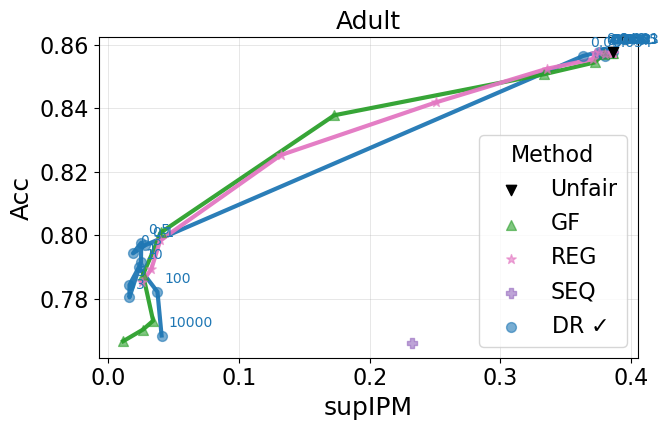

[INFO] saved -> ../final_plots2/adult/adult_0.01_supIPM.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


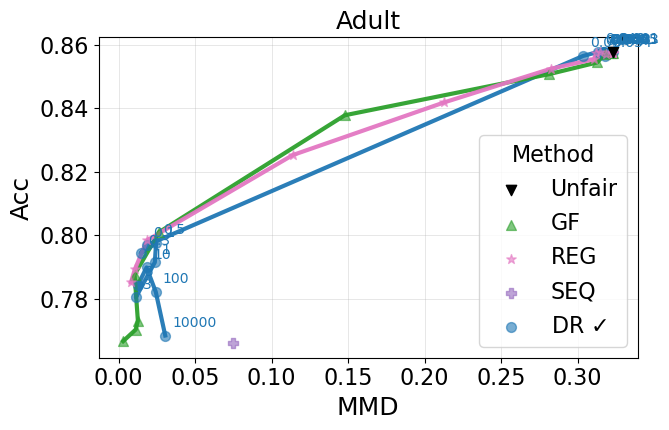

[INFO] saved -> ../final_plots2/adult/adult_0.01_MMD.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


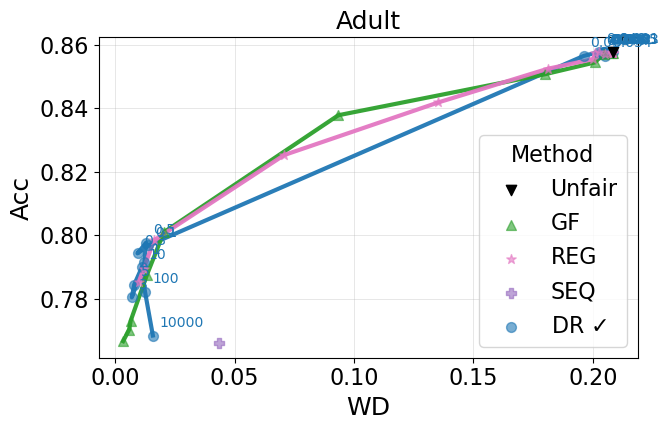

[INFO] saved -> ../final_plots2/adult/adult_0.01_WD.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


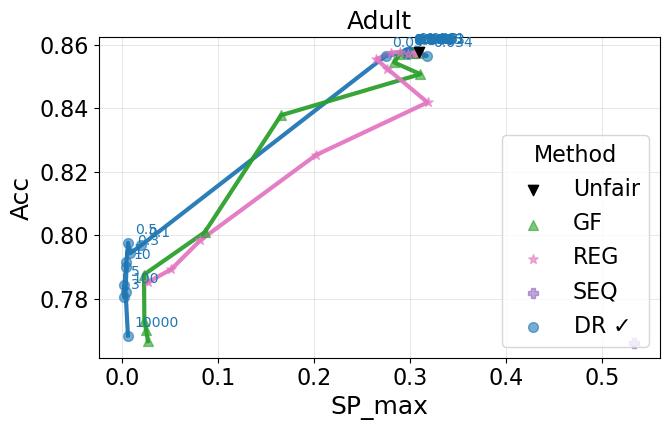

[INFO] saved -> ../final_plots2/adult/adult_0.01_SP_max.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


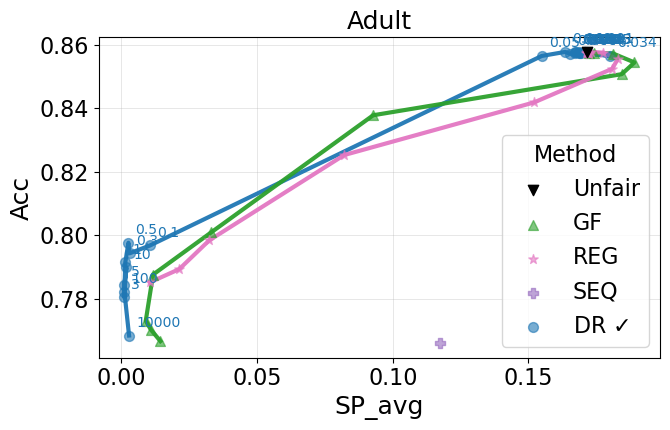

[INFO] saved -> ../final_plots2/adult/adult_0.01_SP_avg.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


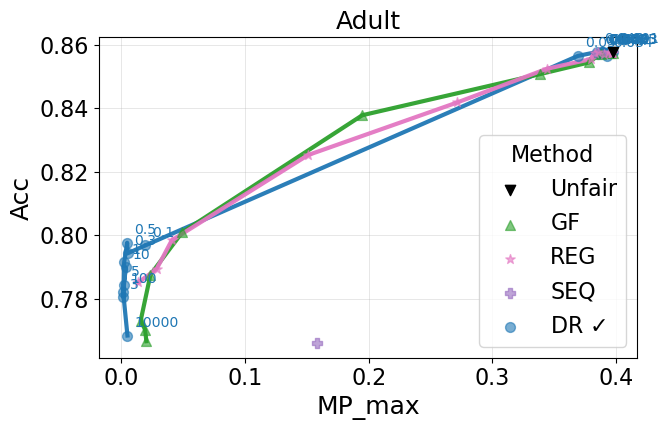

[INFO] saved -> ../final_plots2/adult/adult_0.01_MP_max.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


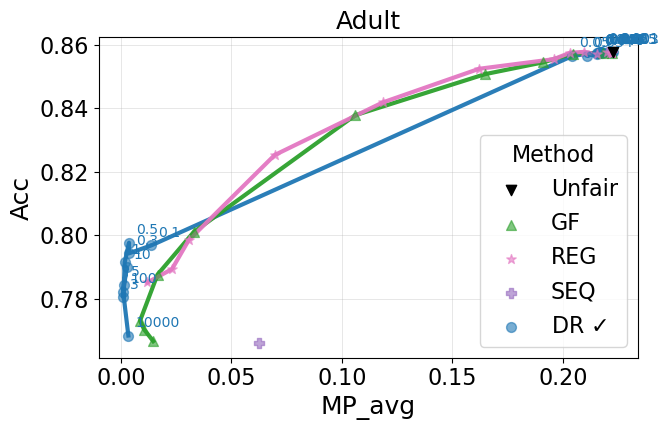

[INFO] saved -> ../final_plots2/adult/adult_0.01_MP_avg.png
=== dataset=sparse_adult, nlow=0.01 ===


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


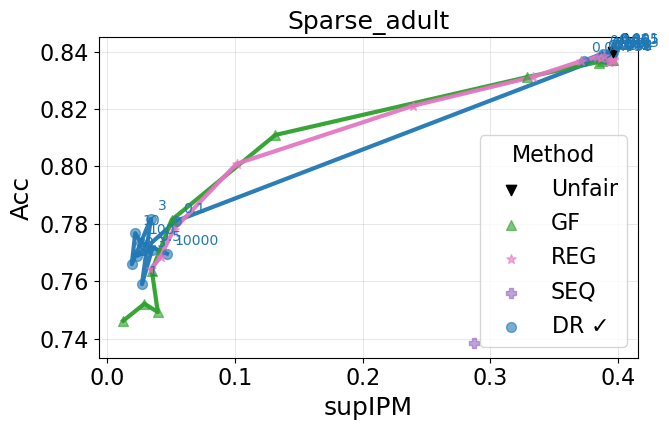

[INFO] saved -> ../final_plots2/sparse_adult/sparse_adult_0.01_supIPM.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


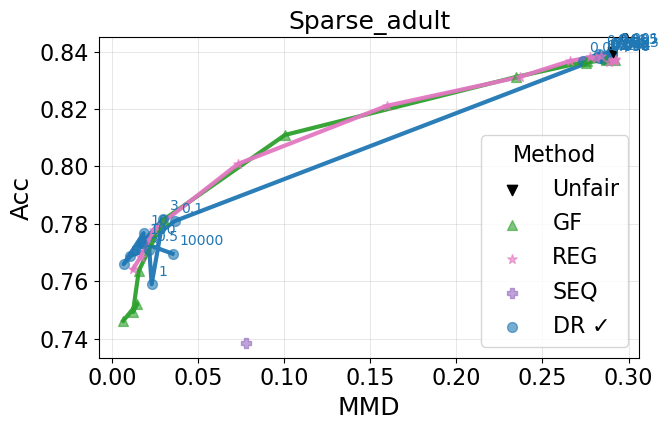

[INFO] saved -> ../final_plots2/sparse_adult/sparse_adult_0.01_MMD.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


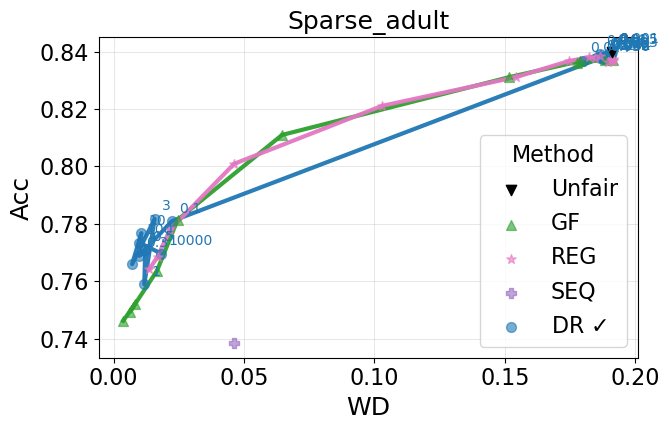

[INFO] saved -> ../final_plots2/sparse_adult/sparse_adult_0.01_WD.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


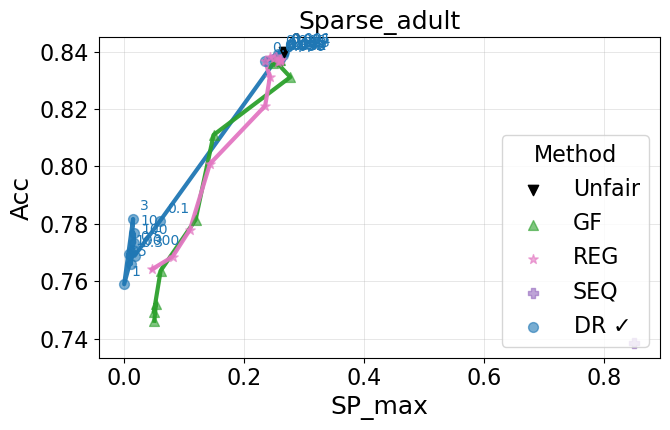

[INFO] saved -> ../final_plots2/sparse_adult/sparse_adult_0.01_SP_max.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


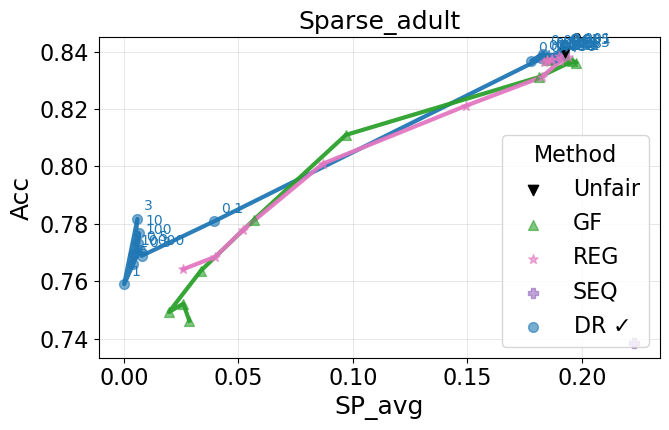

[INFO] saved -> ../final_plots2/sparse_adult/sparse_adult_0.01_SP_avg.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


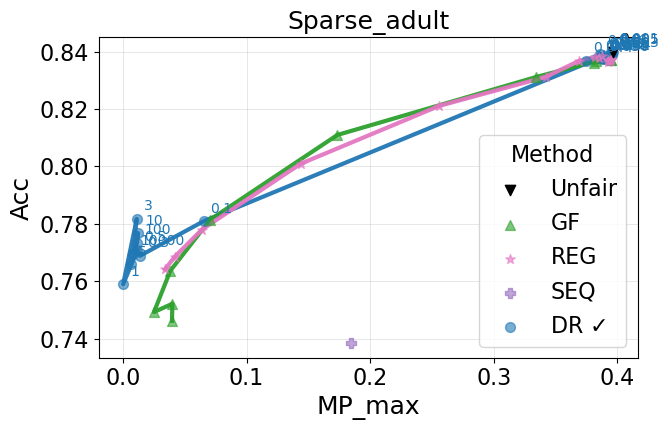

[INFO] saved -> ../final_plots2/sparse_adult/sparse_adult_0.01_MP_max.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


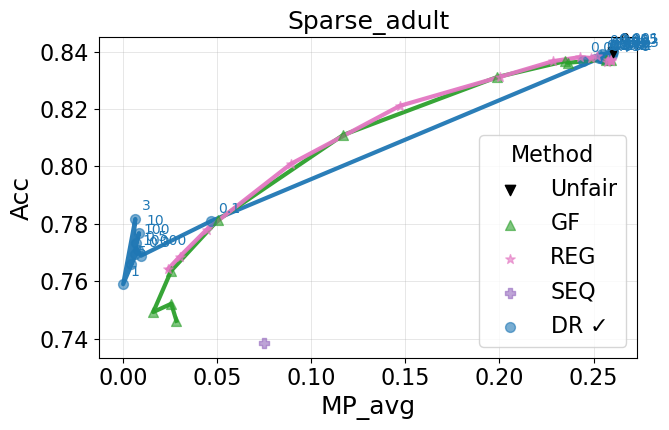

[INFO] saved -> ../final_plots2/sparse_adult/sparse_adult_0.01_MP_avg.png
=== dataset=dutch, nlow=0.01 ===
[WARN] 읽기 실패: ../0916val_5_results/sequential_dutch/all_results.csv (Error tokenizing data. C error: Expected 72 fields in line 4, saw 100
)


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


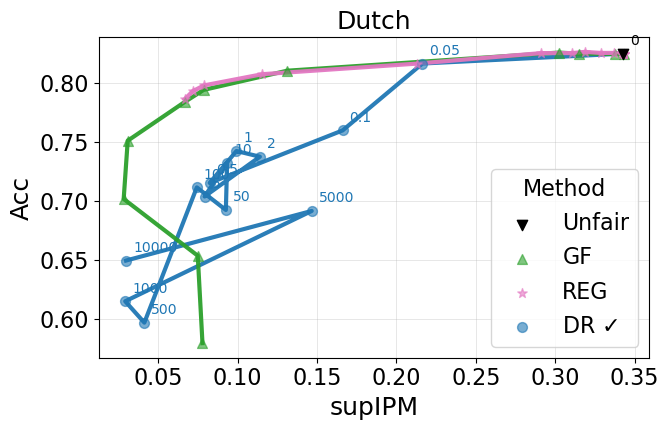

[INFO] saved -> ../final_plots2/dutch/dutch_0.01_supIPM.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


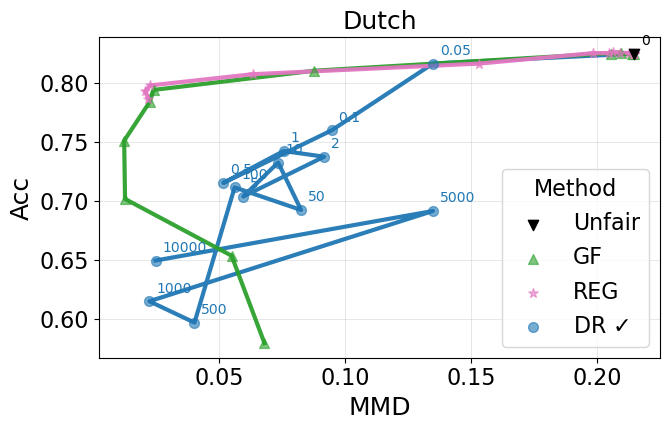

[INFO] saved -> ../final_plots2/dutch/dutch_0.01_MMD.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


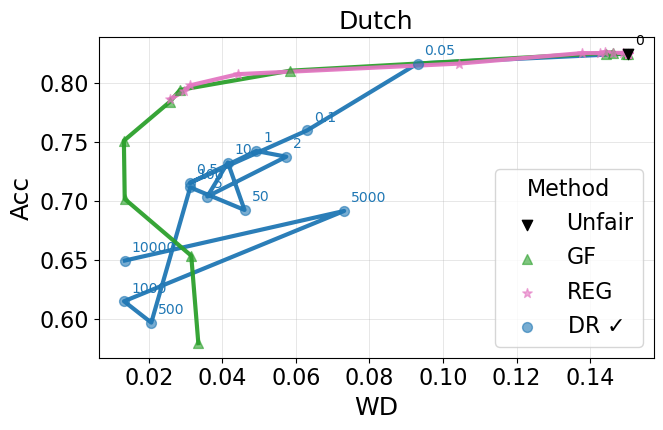

[INFO] saved -> ../final_plots2/dutch/dutch_0.01_WD.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


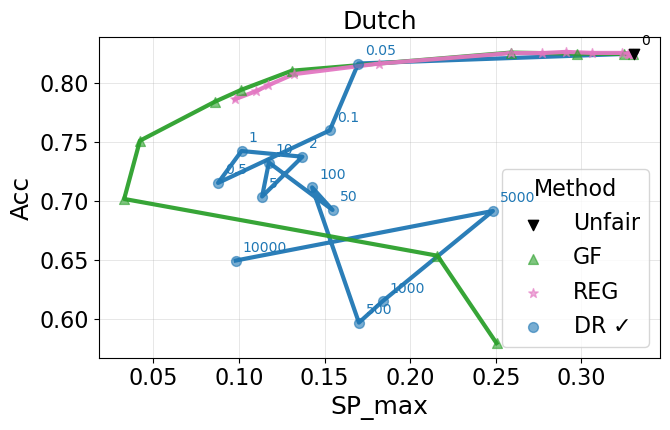

[INFO] saved -> ../final_plots2/dutch/dutch_0.01_SP_max.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


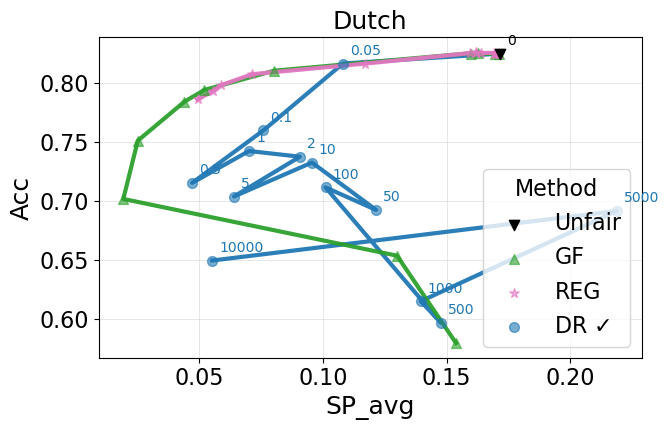

[INFO] saved -> ../final_plots2/dutch/dutch_0.01_SP_avg.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


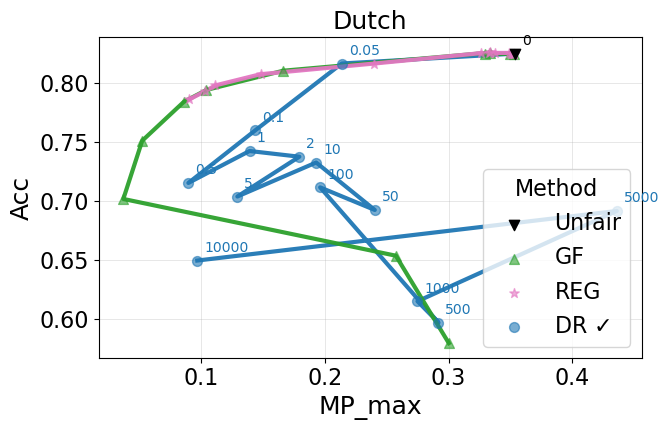

[INFO] saved -> ../final_plots2/dutch/dutch_0.01_MP_max.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


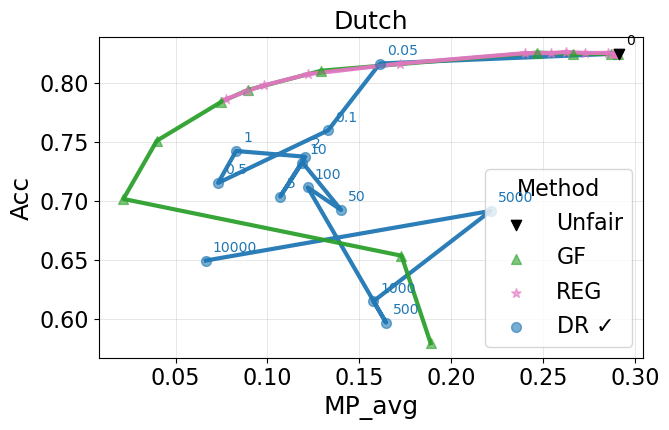

[INFO] saved -> ../final_plots2/dutch/dutch_0.01_MP_avg.png
=== dataset=communities, nlow=0.01 ===


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


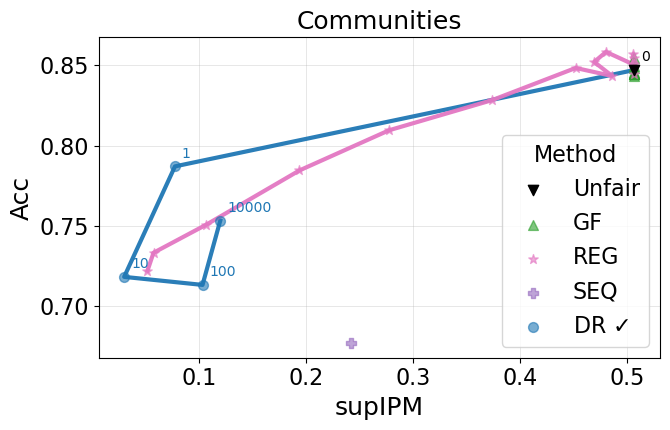

[INFO] saved -> ../final_plots2/communities/communities_0.01_supIPM.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


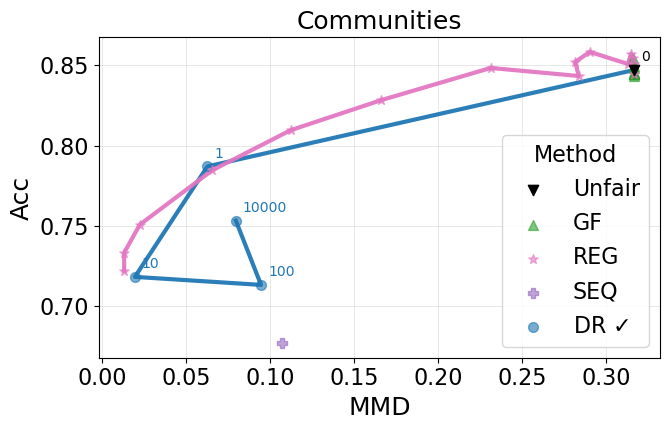

[INFO] saved -> ../final_plots2/communities/communities_0.01_MMD.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


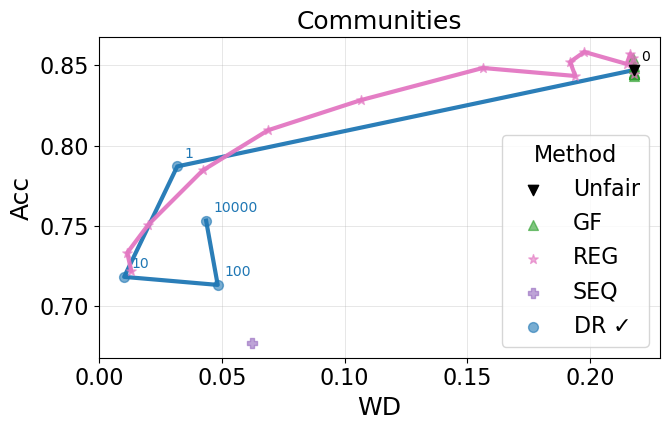

[INFO] saved -> ../final_plots2/communities/communities_0.01_WD.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


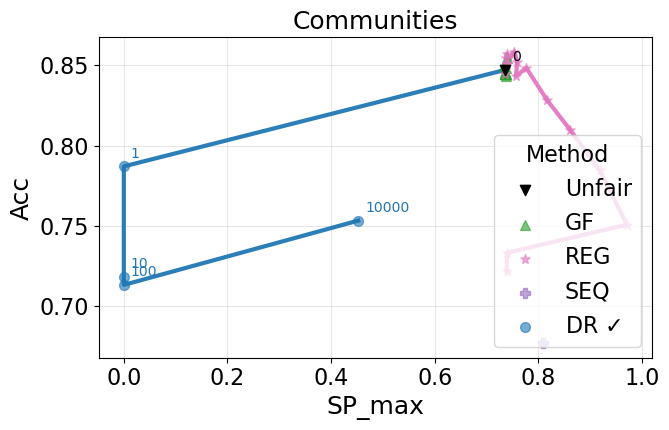

[INFO] saved -> ../final_plots2/communities/communities_0.01_SP_max.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


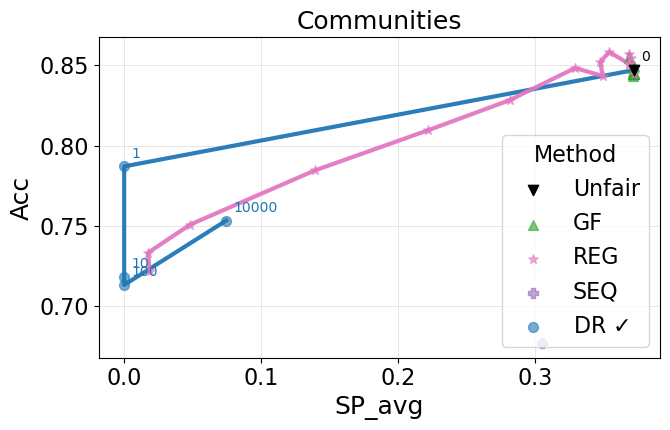

[INFO] saved -> ../final_plots2/communities/communities_0.01_SP_avg.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


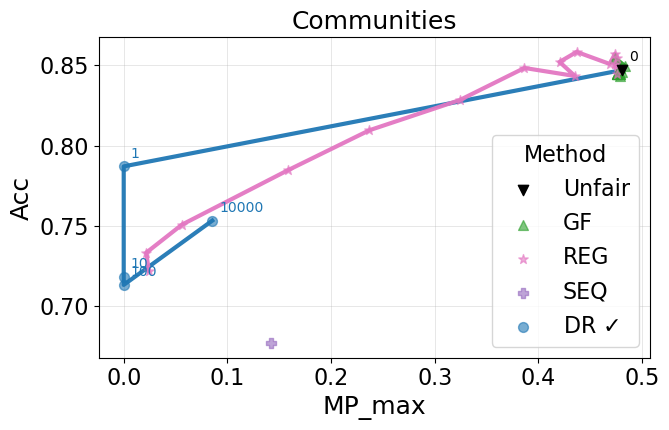

[INFO] saved -> ../final_plots2/communities/communities_0.01_MP_max.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


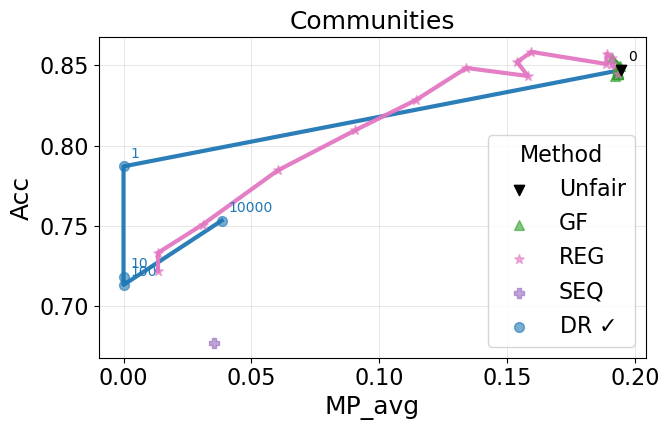

[INFO] saved -> ../final_plots2/communities/communities_0.01_MP_avg.png
=== dataset=civilcomments, nlow=0.01 ===


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


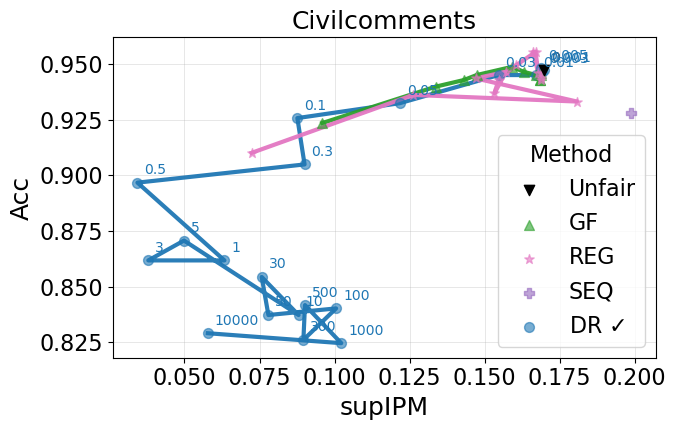

[INFO] saved -> ../final_plots2/civilcomments/civilcomments_0.01_supIPM.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


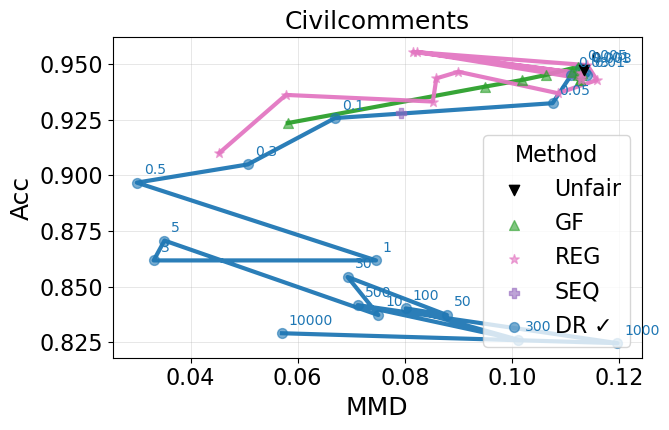

[INFO] saved -> ../final_plots2/civilcomments/civilcomments_0.01_MMD.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


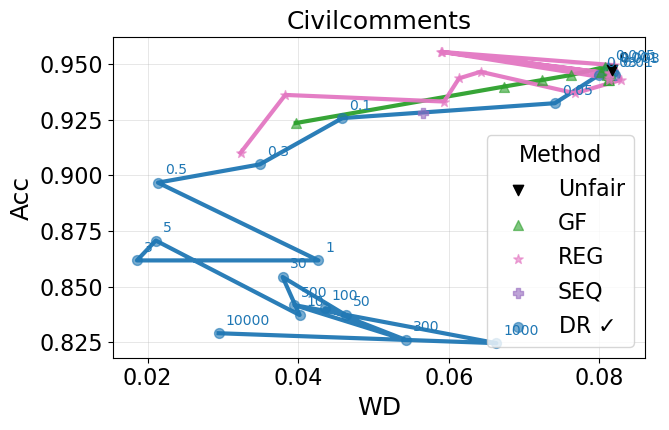

[INFO] saved -> ../final_plots2/civilcomments/civilcomments_0.01_WD.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


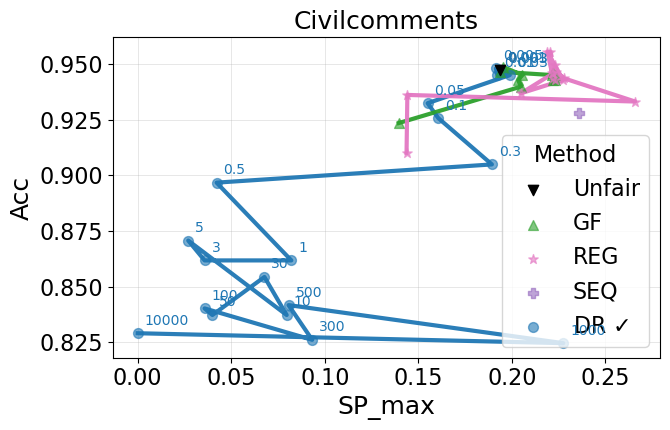

[INFO] saved -> ../final_plots2/civilcomments/civilcomments_0.01_SP_max.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


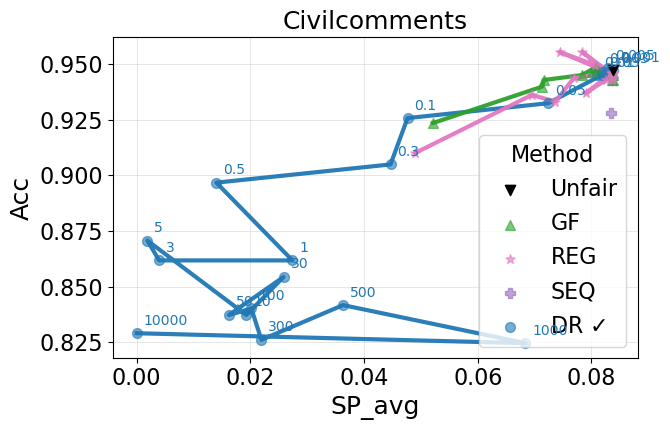

[INFO] saved -> ../final_plots2/civilcomments/civilcomments_0.01_SP_avg.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


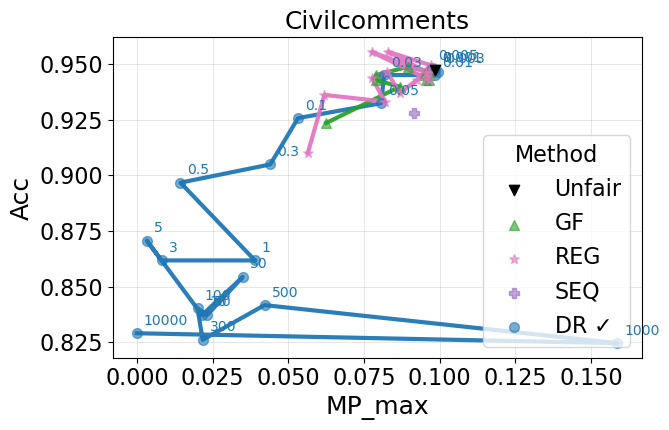

[INFO] saved -> ../final_plots2/civilcomments/civilcomments_0.01_MP_max.png


/tmp/ipykernel_3573786/581236204.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(methods)))


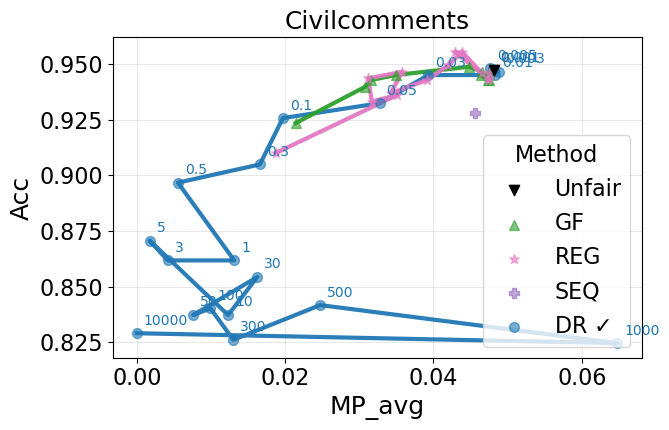

[INFO] saved -> ../final_plots2/civilcomments/civilcomments_0.01_MP_avg.png
=== dataset=civilcomments2, nlow=0.01 ===


FileNotFoundError: CSV_PATTERNS에 맞는 파일이 없습니다.

In [3]:

for dataset in datasets:
    if dataset not in nlow_dict:
        continue  # dict에 없는 데이터셋은 스킵
    for nlow in [nlow_dict[dataset][2]]:
        csv_patterns = [
            f"../0917final2_results/{nlow}/dr_{dataset}/all_results.csv",
            f"../0916val_5_results/gerryfair_{dataset}/all_results.csv",
            f"../0916val_5_results/reg_{dataset}/all_results.csv",
            f"../0916val_5_results/sequential_{dataset}/all_results.csv",
        ]
        print(f"=== dataset={dataset}, nlow={nlow} ===")
        main(
            dataset,
            csv_patterns,
            nlow,
            title=f"nlow={nlow}, dataset={dataset}",
            path=f"../final_plots2/{dataset}/"
        )

In [15]:

for dataset in datasets:
    if dataset not in nlow_dict:
        continue  # dict에 없는 데이터셋은 스킵
    for nlow in nlow_dict[dataset]:
        csv_patterns = [
            f"../0917final2_results/{nlow}/dr_{dataset}/all_results.csv",
            f"../0916val_5_results/gerryfair_{dataset}/all_results.csv",
            f"../0916val_5_results/reg_{dataset}/all_results.csv",
            f"../0916val_5_results/sequential_{dataset}/all_results.csv",
        ]
        print(f"=== dataset={dataset}, nlow={nlow} ===")
        main(
            dataset,
            csv_patterns,
            nlow,
            title=f"nlow={nlow}, dataset={dataset}",
            path=f"../final_plots2/{dataset}/"
        )

In [ ]:

for dataset in datasets:
    if dataset not in nlow_dict:
        continue  # dict에 없는 데이터셋은 스킵
    for nlow in nlow_dict[dataset]:
        csv_patterns = [
            f"../0917final_results/{nlow}/dr_{dataset}/all_results.csv",
            f"../0916val_5_results/gerryfair_{dataset}/all_results.csv",
            f"../0916val_5_results/reg_{dataset}/all_results.csv",
        ]
        print(f"=== dataset={dataset}, nlow={nlow} ===")
        main(
            dataset,
            csv_patterns,
            nlow,
            title=f"nlow={nlow}, dataset={dataset}",
            path=f"../final_plots/{dataset}/"
        )